In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt

import numpy as np
import sys
DCNFDE_PATH = '/notebooks/research/depth-estimation/cs8990'
if DCNFDE_PATH not in sys.path:
    sys.path.append(DCNFDE_PATH)

from dcnfde.models import test_im, test_weight
from dcnfde.models import make_DCNF_VGG16, load_VGG16, make_superpixel_pooling
from keras.models import Model

Using TensorFlow backend.


In [2]:
def myimshow(im):
    plt.figure(figsize=(7,7))
    plt.imshow(im[...,::-1]/255)
    
def show_unary_from(conv_map):
    H_test = np.einsum('tij,ijk->tk', test_weight, conv_map)
    show_unary(H_test)
    
def show_unary(H_test):
    plt.figure(figsize=(10,7))
    plt.imshow(H_test, cmap='jet')

def show_conv_map(conv_map):
    N_sumples = 16
    sample = np.random.choice(range(conv_map.shape[1]), N_sumples, False)
    conv_map = conv_map.transpose((2,0,1))
    print('%d convmaps out of %d.'%(N_sumples, conv_map.shape[0]))
    print('shape:', conv_map.shape[1:])
    plt.figure(figsize=(10,10))
    for i in xrange(N_sumples):
        plt.subplot(4,4,i+1)
        # plt.axis('off')
        plt.imshow(conv_map[sample[i]], cmap=plt.get_cmap('inferno'), vmin=0, vmax=255)

In [3]:
spp = Model(**make_superpixel_pooling())
load_VGG16(spp)

vgg = Model(**make_DCNF_VGG16())
load_VGG16(vgg)
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv11 (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv12 (Conv2D)              (None, 224, 224, 64)      36928     
_________________________________________________________________
max1 (MaxPooling2D)          (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 114, 114, 64)      0         
__________

In [4]:
im = test_im.copy()
im[:,:] -= np.array([103.939, 116.779, 123.68])
im = im[np.newaxis, ...]
convmap = vgg.predict(im)
print(convmap.shape)

(1, 28, 28, 512)


16 convmaps out of 512.
shape: (28, 28)


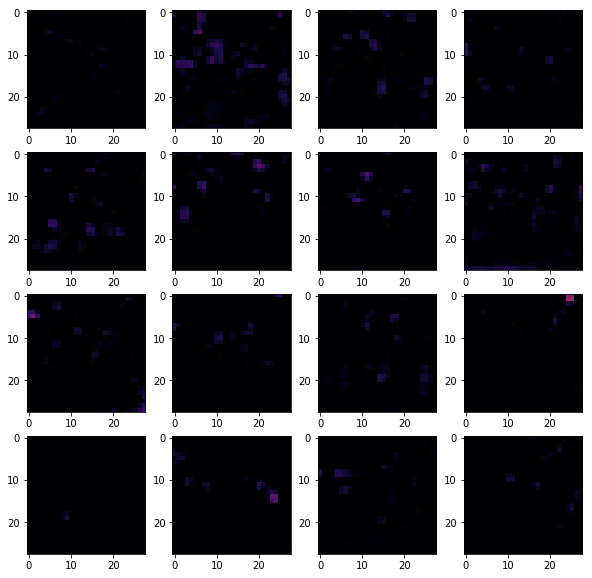

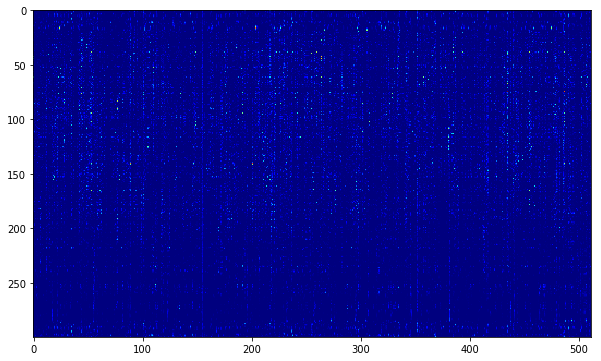

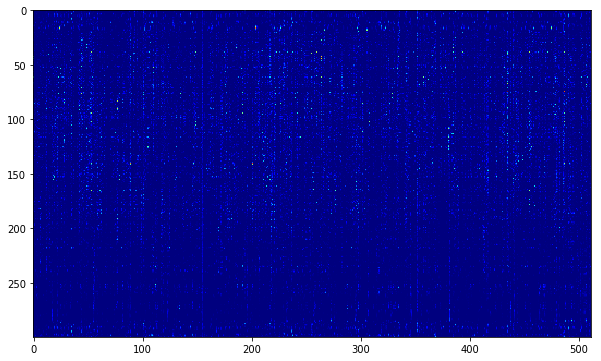

In [5]:
im = test_im.copy()
im[:,:] -= np.array([103.939, 116.779, 123.68])
im = im[np.newaxis, ...]
w = test_weight.copy()[np.newaxis, ...]
# print(im.shape, w.shape)
spp_results, spp_convmaps = spp.predict([im, w])

show_conv_map(spp_convmaps[0])
show_unary_from(spp_convmaps[0])
show_unary(spp_results[0])

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, merge
from keras.layers.core import Flatten, Dense, Dropout, Merge, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import h5py
import numpy as np
import os

class Unary(object):
    """ np.einsum('tij,kij->tk', test_weight, conv_map[0]) """
    def __init__(self, vgg_weights_path):
        convmap = ConvMap(vgg_weights_path).model
        
        images = Input(shape=(3,224,224))
        superpixels = Input(shape=(300, 28, 28))
        convmap_output = convmap(images)
        
        spp = merge([convmap_output, superpixels],
            mode = lambda (W, CM): tf.einsum('ntij,nkij->ntk', W, CM),
            output_shape = (300, 512))
        
        self.model = Model(input = [images, superpixels], output = spp)#output = [spp, convmap_output])
        # self.model.summary()
        
    def predict_one(self, im, w):
        im = im.copy()
        im[:,:] -= np.array([103.939, 116.779, 123.68])
        im = im.transpose((2,0,1))
        im = np.expand_dims(im, axis=0)
        w = np.expand_dims(w, axis=0)
        r = self.model.predict([im, w])
        return r